In [1]:
from pkg.word2vec_vocab import docs_to_vocab_ids,embedding_matrix
from pkg.show_comparison import make_plot

import numpy as np
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_text as tf_text

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,SpatialDropout1D,LSTM
from keras.callbacks import EarlyStopping

import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import pandas as pd
pd.set_option('max_columns', None)

from pkg.data_frame import eda_nltk, remove_tags

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)


import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!
2023-09-20 22:07:10.831059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataframe = input(': ') #data/reviews_Automotive_5.json.gz
df = eda_nltk(dataframe)
df.head()

:  data/reviews_Automotive_5.json.gz


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


# EDA
## add a new column for sentiment


(20473, 10)


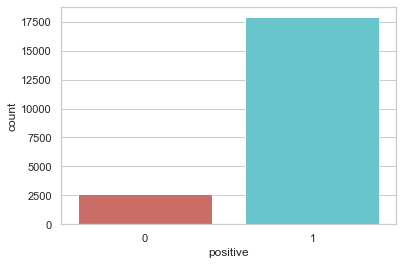

In [3]:
df['positive'] = df.overall.apply(lambda x: 1 if x >= 4 else 0)
print(df.shape)

review_df = df[['reviewText','positive']]
review_df['reviewText']=review_df['reviewText'].apply(lambda cw : remove_tags(cw))


sns.countplot(x='positive',data = review_df, palette = 'hls')
plt.show()

## handling the imbalanced data

In [4]:
max_cnt = review_df.query('positive == 0').shape[0]
print(f'We should select only {max_cnt} count for both positive/ negative review')
sample_df = review_df.groupby(['positive']).apply(lambda x: x.sample(max_cnt))
sample_df.shape[0]

We should select only 2578 count for both positive/ negative review


5156

In [5]:
s = 0.0
for i in sample_df['reviewText']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/sample_df.shape[0])
pos = 0
for i in range(sample_df.shape[0]):
    if sample_df.iloc[i]['positive'] == 1:
        pos = pos + 1
neg = sample_df.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/sample_df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/sample_df.shape[0]*100)+"%")

Average length of each review :  98.49825446082234
Percentage of reviews with positive sentiment is 50.0%
Percentage of reviews with negative sentiment is 50.0%


# let's tokenize the data

In [6]:
sample_df[:2]['reviewText']

positive       
0         7136     although it looks to be made with a thick stur...
          14445    price was attractive but very poor quality con...
Name: reviewText, dtype: object

In [7]:
X = sample_df['reviewText']
y = sample_df['positive']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)

In [8]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(X_train)
test_tokens = tokenizer.tokenize(X_test)

train_tokens[0]

<tf.Tensor: shape=(117,), dtype=string, numpy=
array([b'i', b'am', b'sort', b'of', b'a', b'towel', b'snob', b'and',
       b'have', b'many', b'assortments', b'of', b'various', b'towels',
       b'to', b'perform', b'various', b'tasks', b'i', b'have', b'some',
       b'other', b'microfiber', b'towels', b'with', b'which', b'to',
       b'compare', b'these', b'to', b'which', b'are', b'much', b'better',
       b'quality', b'these', b'are', b'rather', b'thin', b'you', b'can',
       b'hold', b'them', b'up', b'to', b'the', b'light', b'and', b'see',
       b'through', b'them', b'although', b'thinner', b'towels', b'can',
       b'come', b'in', b'handy', b'sometimes', b'these', b'seem', b'a',
       b'bit', b'flimsy', b'and', b'cheap', b'looking', b'in', b'my',
       b'opinion', b'and', b'they', b'really', b'don', b't', b'look',
       b'like', b'they', b'will', b'hold', b'up', b'a', b'long', b'time',
       b'as', b'there', b'are', b'a', b'lot', b'of', b'strings',
       b'poking', b'out', b'a

In [9]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(Y_train)
test_labels = np.array(Y_test)

test_labels[:4]

Examples processed:  0
Total examples:  4123
Examples processed:  0
Total examples:  1031


array([1, 1, 1, 1])

In [11]:
# def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
#     cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
#     cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
#                                     embedding_matrix.shape[1],
#                                     embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
#                                     input_length=MAX_SEQUENCE_LENGTH,
#                                     trainable=embeddings_trainable)
#     cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

#     conv_layers_for_all_kernel_sizes = []
#     for kernel_size, filters in zip(kernel_sizes, num_filters):
#         conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
#         conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
#         conv_layers_for_all_kernel_sizes.append(conv_layer)
    
#     conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
#     last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

#     for dense_layer_dim in dense_layer_dims:
#         last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
#     cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

#     cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
#     cnn_model.compile(optimizer='adam',
#                       loss='binary_crossentropy',  # From information theory notebooks.
#                       metrics=['accuracy'])
#     return cnn_model

In [12]:
MAX_SEQUENCE_LENGTH = 128
# num_filters = [100, 100, 50, 25]
# kernel_sizes = [3, 4, 5, 10]
# dense_layer_dims = [100, 50]
# dropout_rate = 0.5

# cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)
# cnn_model.summary()

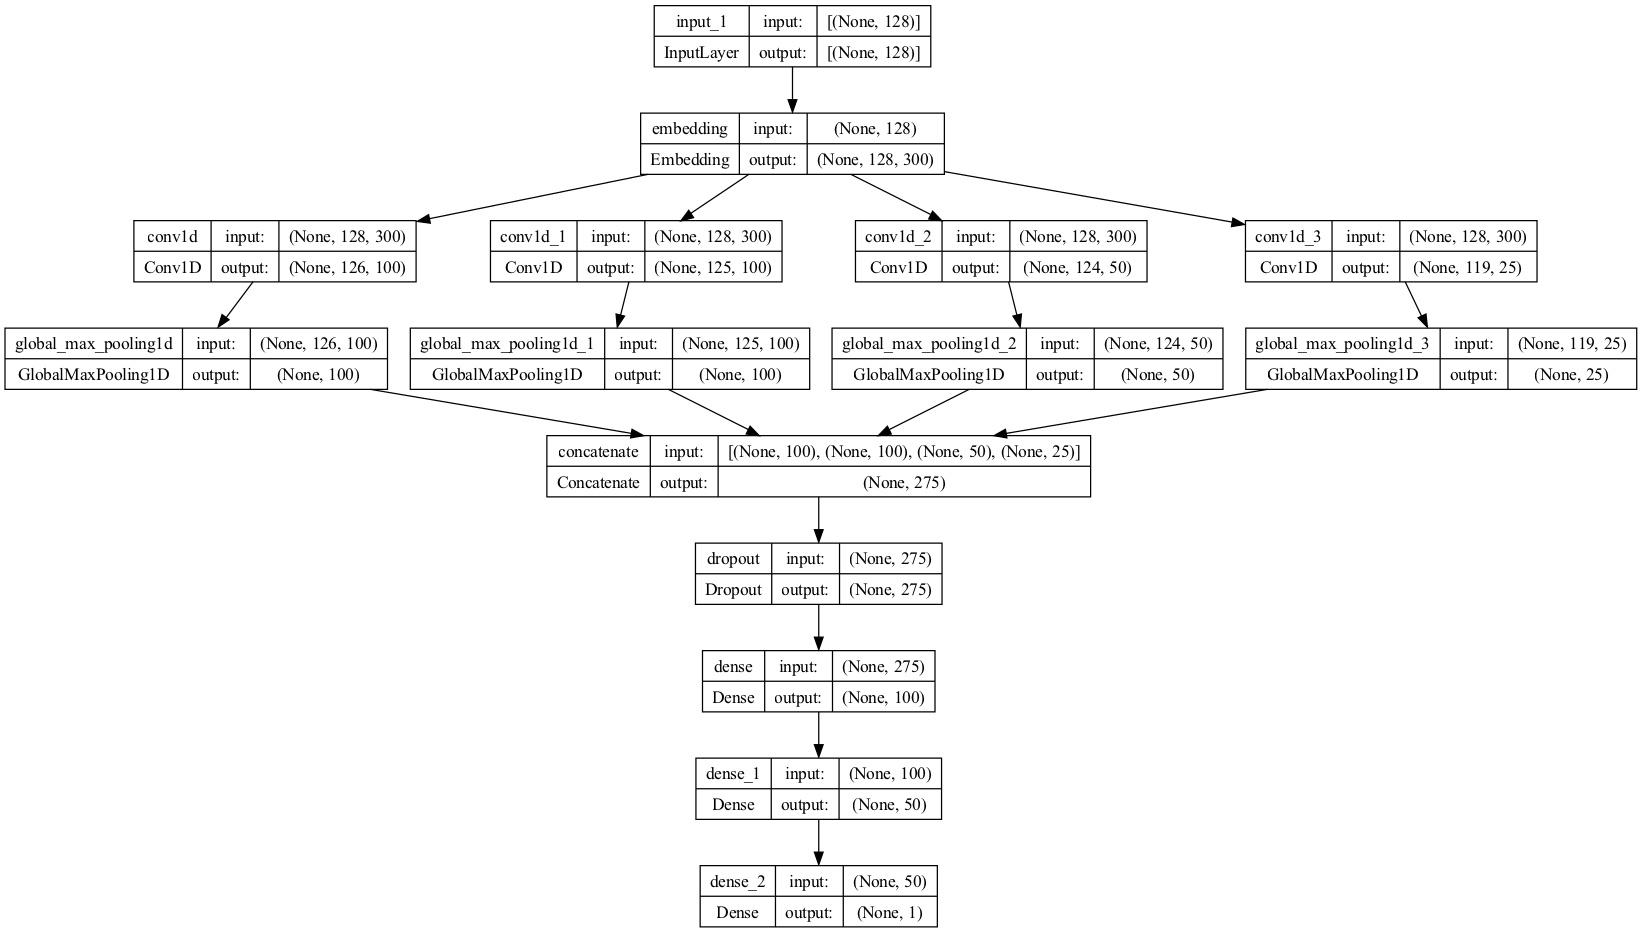

In [13]:
# plot_model(cnn_model, show_shapes=True, dpi=90)

In [14]:
# cnn_history = cnn_model.fit(train_input,
#                             train_labels,
#                             validation_data=(test_input, test_labels),
#                             batch_size=32,
#                             epochs=5
#                             )

Epoch 1/5
129/129 [==============================] - 10s 69ms/step - loss: 0.6710 - accuracy: 0.5805 - val_loss: 0.5965 - val_accuracy: 0.7083
Epoch 2/5
129/129 [==============================] - 9s 67ms/step - loss: 0.5747 - accuracy: 0.6986 - val_loss: 0.5469 - val_accuracy: 0.7229
Epoch 3/5
129/129 [==============================] - 9s 66ms/step - loss: 0.4887 - accuracy: 0.7653 - val_loss: 0.5191 - val_accuracy: 0.7422
Epoch 4/5
129/129 [==============================] - 9s 68ms/step - loss: 0.4010 - accuracy: 0.8164 - val_loss: 0.5181 - val_accuracy: 0.7461
Epoch 5/5
129/129 [==============================] - 9s 68ms/step - loss: 0.3055 - accuracy: 0.8698 - val_loss: 0.5196 - val_accuracy: 0.7694


# Now start building LSTM model

## let s begin with a basic LSTM


In [10]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

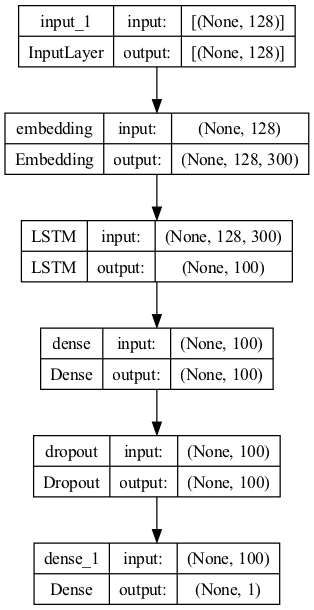

In [13]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [19]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
129/129 [==============================] - 16s 121ms/step - loss: 0.6744 - accuracy: 0.5669 - val_loss: 0.6938 - val_accuracy: 0.5388
Epoch 2/5
129/129 [==============================] - 16s 124ms/step - loss: 0.6667 - accuracy: 0.5781 - val_loss: 0.6945 - val_accuracy: 0.4700
Epoch 3/5
129/129 [==============================] - 16s 123ms/step - loss: 0.6569 - accuracy: 0.5815 - val_loss: 0.7047 - val_accuracy: 0.5310
Epoch 4/5
129/129 [==============================] - 16s 123ms/step - loss: 0.6473 - accuracy: 0.5890 - val_loss: 0.7016 - val_accuracy: 0.5329
Epoch 5/5
129/129 [==============================] - 16s 125ms/step - loss: 0.6341 - accuracy: 0.6043 - val_loss: 0.7482 - val_accuracy: 0.5368


# Stacked LSTMs

In [15]:
def build_stacked_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the stacked one
    #first one is called sequence output and change return_seq = True
    rnn_seq_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=True, return_state=False, name='LSTM1')\
        (rnn_embeddings)
    
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM2')\
        (rnn_seq_output) # calc the seq here
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

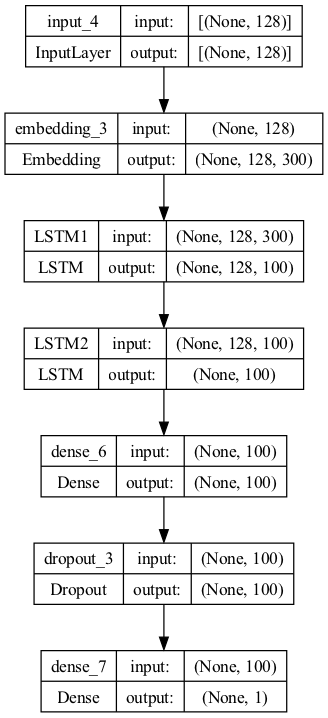

In [20]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

stack_rnn_model = build_stacked_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(stack_rnn_model, show_shapes=True, dpi=90)

In [21]:
stacked_rnn_history = stack_rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
129/129 [==============================] - 20s 132ms/step - loss: 0.6920 - accuracy: 0.5245 - val_loss: 0.6903 - val_accuracy: 0.4903
Epoch 2/5
129/129 [==============================] - 16s 123ms/step - loss: 0.6883 - accuracy: 0.5436 - val_loss: 0.6874 - val_accuracy: 0.5640
Epoch 3/5
129/129 [==============================] - 15s 120ms/step - loss: 0.6882 - accuracy: 0.5458 - val_loss: 0.6864 - val_accuracy: 0.5678
Epoch 4/5
129/129 [==============================] - 16s 125ms/step - loss: 0.6855 - accuracy: 0.5485 - val_loss: 0.6865 - val_accuracy: 0.5543
Epoch 5/5
129/129 [==============================] - 16s 125ms/step - loss: 0.6855 - accuracy: 0.5533 - val_loss: 0.6873 - val_accuracy: 0.5581


## let's compare this LSTM with Basic RNN and Stacked RNN results

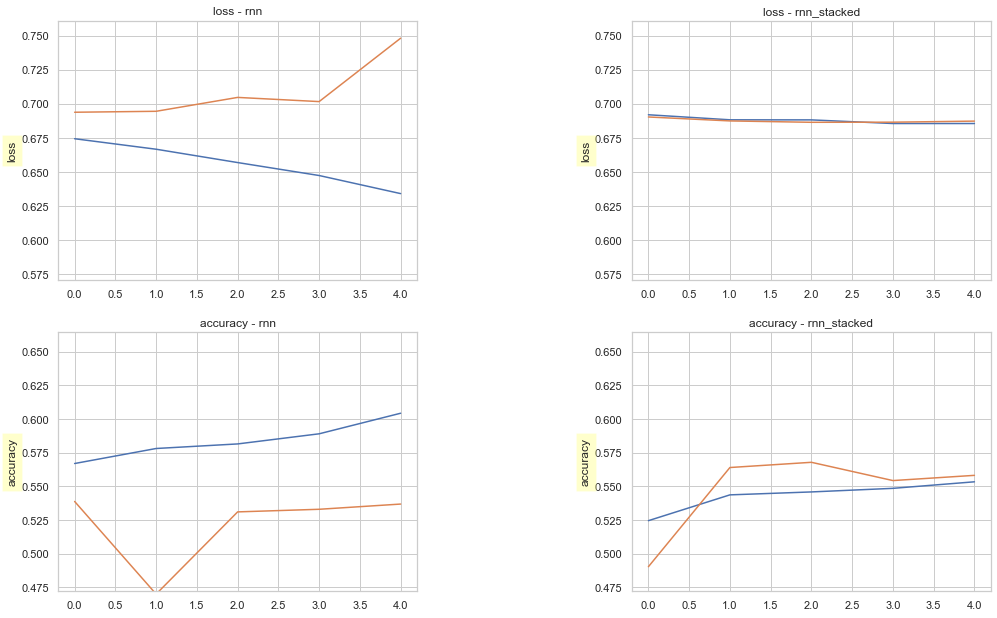

In [24]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          rnn_history, 
          stacked_rnn_history, 
          model_1_name='rnn',
          model_2_name='rnn_stacked')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# Bi Directional 

In [30]:
def build_bidirectional_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Now do the Bidirectional one
    #first one is called sequence output and change return_seq = True
    rnn_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM1'))\
        (rnn_embeddings)
    
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

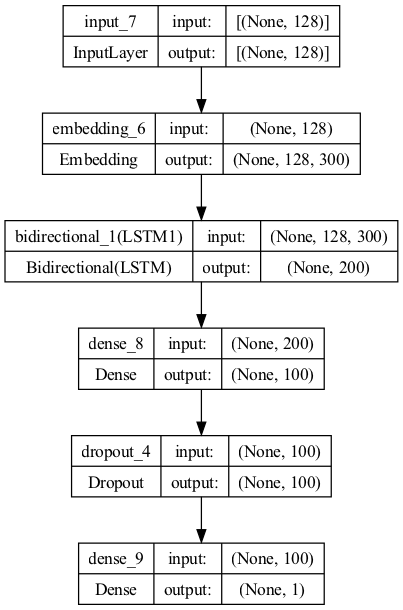

In [31]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

bi_rnn_model = build_bidirectional_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(bi_rnn_model, show_shapes=True, dpi=90)

In [32]:
bi_rnn_history = bi_rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
129/129 [==============================] - 18s 116ms/step - loss: 0.6678 - accuracy: 0.5989 - val_loss: 0.6726 - val_accuracy: 0.5804
Epoch 2/5
129/129 [==============================] - 15s 118ms/step - loss: 0.6042 - accuracy: 0.6693 - val_loss: 0.5950 - val_accuracy: 0.6686
Epoch 3/5
129/129 [==============================] - 14s 112ms/step - loss: 0.5661 - accuracy: 0.7061 - val_loss: 0.5680 - val_accuracy: 0.7141
Epoch 4/5
129/129 [==============================] - 15s 116ms/step - loss: 0.5604 - accuracy: 0.7146 - val_loss: 0.5802 - val_accuracy: 0.7035
Epoch 5/5
129/129 [==============================] - 15s 115ms/step - loss: 0.5475 - accuracy: 0.7177 - val_loss: 0.5629 - val_accuracy: 0.7345


# since Basic RNN has better performance than stacked 
## let's compare this LSTM with Basic RNN and BiDirectional RNN results

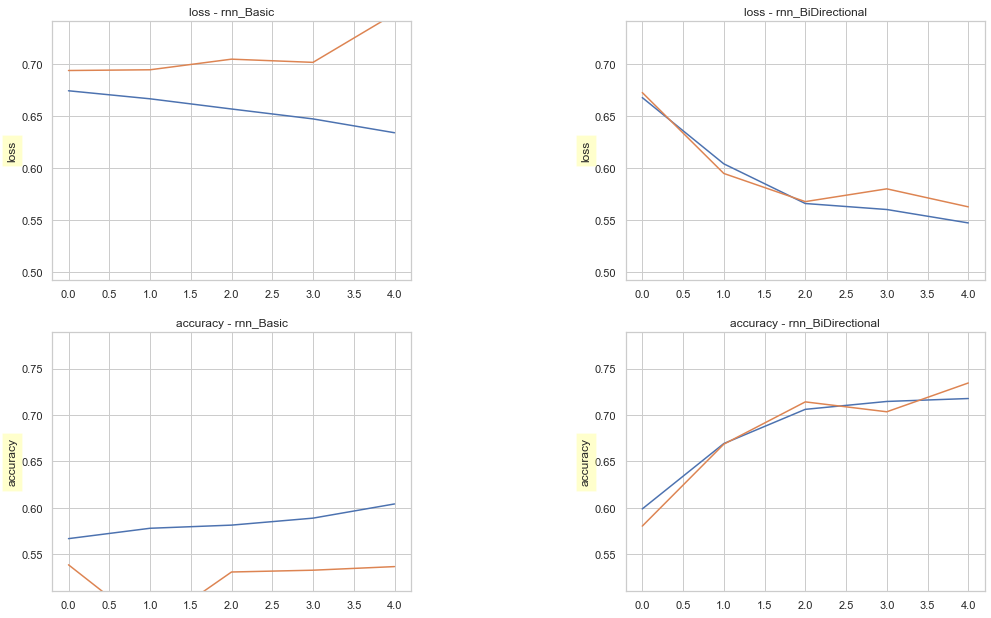

In [33]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          rnn_history, 
          bi_rnn_history, 
          model_1_name='rnn_Basic',
          model_2_name='rnn_BiDirectional')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()